# Intersection Crash Analysis Using Only Intersection Characteristics

Linear regression analysis of factors affecting red light crashes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [2]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db


In [3]:
print(sql_fetch_tables(c, conn))
#table_info(c, conn)  # use if you need to see columns

[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('all_days',), ('all_hours',), ('daily_covid',)]


## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [4]:
table_info(c, conn)

cam_locations
	-camera_id
	-intersection
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-beat_of_occurrence
	-num_units
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-crash_hour
	-crash_day_of_week
	-crash_month
	-latitude
	-longitude
	-lane_cnt
	-interse

In [5]:
#create my db
crash_df = pd.read_sql_query('''
WITH v AS(SELECT dv.intersection,
                SUM(dv.violations) as violations,
                (CASE
                      WHEN JulianDay(se.start) <= JulianDay('2017-09-01 00:00:00')
                      AND JulianDay(se.end) > JulianDay('2020-12-31 00:00:00')
                          THEN CAST(JulianDay('2020-12-31 00:00:00') - JulianDay('2017-09-01 00:00:00') as Integer)
                      
                      WHEN JulianDay(se.start) > JulianDay('2017-09-01 00:00:00')
                      AND JulianDay(se.end) > JulianDay('2020-12-31 00:00:00')
                          THEN CAST (JulianDay('2020-12-31 00:00:00') - JulianDay(se.start) as Integer)
                      
                      WHEN JulianDay(se.start) > JulianDay('2017-09-01 00:00:00')
                      AND JulianDay(se.end) <= JulianDay('2020-12-31 00:00:00')
                          THEN CAST ((se.end) - JulianDay(se.start) as Integer)
                    
                      ELSE CAST (JulianDay(se.end) - JulianDay('2017-09-01 00:00:00') as Integer)
                END) AS days_active,
                COUNT(DISTINCT dv.camera_id) as n_cams,
                start,
                end,
                dv.day,
                dv.month,
                dv.year,
                dv.intersection

        FROM daily_violations as dv
        LEFT JOIN int_startend as se
            ON dv.intersection = se.intersection

        GROUP BY dv.year, dv.month, dv.day, dv.intersection
        ), 

    ic AS(SELECT *
         FROM intersection_chars
        ),

    cr AS(SELECT *   
         FROM signal_crashes
         GROUP BY year, month, day, intersection
        ),
    
    ah AS(SELECT * FROM all_hours GROUP BY year, month, day, intersection),
    
    rg AS(SELECT region_id, intersection
        FROM intersection_cams
        GROUP BY intersection)

SELECT 
    (CAST(365 * SUM(cr.injuries_total) AS FLOAT) / 1217) as injuries_per_year,
    (CAST(365 * COUNT(cr.crash_record_id) AS FLOAT)/ 1217) as crash_per_year,
    ( (CAST(365 * COUNT(cr.crash_record_id) AS FLOAT)/ 1217) +
      (CAST(365 * SUM(cr.injuries_total) AS FLOAT) / 1217) +
      (CAST(365 * SUM(cr.injuries_incapacitating) AS FLOAT) / 1217)) AS danger_metric,

    (CAST(v.days_active AS FLOAT) / 1217) AS active_cam,
    
    (CAST((ic.daily_traffic/ic.total_lanes) AS FLOAT)) as traffic_per_lane,
    ic.protected_turn/ic.way as protected_ratio,
    
    ic.daily_traffic,
    (ic.daily_traffic * 365) /1e6 AS million_cars_per_year,
    SUM(v.violations) as violations,
    

    (ic.exit + ic.triangle + ic.angled + ic.underpass + way/4 + total_lanes/way) as complexity,

    ic.*,
    
    v.n_cams,
    (CAST(SUM(v.violations) AS FLOAT)/ v.days_active) as violations_per_day,
    COUNT(crash_record_id) as n_crash,
    SUM(injuries_total) as injuries_total,
    SUM(injuries_fatal) as injuries_fatal,
    SUM(injuries_non_incapacitating) as injuries_non_incapacitating,
    v.days_active,
    (CAST(ic.total_lanes AS FLOAT)/ic.way) AS lanes_per_direction,  
    
    rg.region_id

FROM ah
LEFT JOIN v
    ON v.year = ah.year
    AND v.month = ah.month
    AND v.day = ah.day
    AND v.intersection = ah.intersection
LEFT JOIN cr
    ON cr.year = ah.year
    AND cr.month = ah.month
    AND cr.day = ah.day
    AND cr.intersection = ah.intersection
LEFT JOIN ic
    ON ah.intersection = ic.intersection
LEFT JOIN rg
    ON ah.intersection = rg.intersection
WHERE ah.date >= \'2017-09-01\' AND ah.date <= \'2020-12-31\'

GROUP BY ah.intersection
ORDER BY ah.intersection
                                    ''', conn)

crash_df.head()

,injuries_per_year,crash_per_year,danger_metric,active_cam,traffic_per_lane,protected_ratio,daily_traffic,million_cars_per_year,violations,complexity,...,speed,n_cams,violations_per_day,n_crash,injuries_total,injuries_fatal,injuries_non_incapacitating,days_active,lanes_per_direction,region_id
0,10.197206,13.496302,24.593262,1.0,7183.0,0,43100,15.7315,14369.0,3,...,35,2.0,11.806902,45,34.0,0.0,18.0,1217.0,1.5,26
1,6.298274,11.396878,17.995070,1.0,6966.0,1,41800,15.2570,15073.0,2,...,35,2.0,12.385374,38,21.0,0.0,11.0,1217.0,1.5,26
2,5.698439,13.196385,19.194741,1.0,3650.0,0,36500,13.3225,17929.0,3,...,35,2.0,14.732128,44,19.0,0.0,11.0,1217.0,2.5,16
3,5.698439,20.394412,26.392769,1.0,5300.0,0,42400,15.4760,7143.0,3,...,35,2.0,5.869351,68,19.0,0.0,14.0,1217.0,2.0,15
4,9.897288,35.090386,45.587510,1.0,4900.0,0,58800,21.4620,6589.0,4,...,40,2.0,5.414133,117,33.0,0.0,19.0,1217.0,3.0,18


In [6]:
crash_df.describe()

,injuries_per_year,crash_per_year,danger_metric,active_cam,traffic_per_lane,protected_ratio,daily_traffic,million_cars_per_year,violations,complexity,...,daily_traffic,speed,n_cams,violations_per_day,n_crash,injuries_total,injuries_fatal,injuries_non_incapacitating,days_active,lanes_per_direction
count,155.000000,156.000000,155.000000,144.000000,156.000000,156.000000,156.000000,156.000000,150.000000,156.000000,...,156.000000,156.000000,144.000000,144.000000,156.000000,155.000000,155.000000,155.000000,144.000000,156.000000
mean,4.663239,11.767930,16.996634,0.993335,8083.519231,0.346154,51333.333333,18.736667,12090.840000,2.852564,...,51333.333333,35.673077,1.868056,9.795875,39.237179,15.548387,0.090323,9.032258,1208.888889,1.617201
std,3.673259,7.209315,10.521973,0.079565,2221.087765,0.477275,14482.858982,5.286244,11618.713223,1.100173,...,14482.858982,3.550854,0.413860,9.258837,24.037635,12.247551,0.400774,7.324057,96.831128,0.455041
min,0.000000,0.000000,0.899753,0.045193,3011.000000,0.000000,21600.000000,7.884000,562.000000,1.000000,...,21600.000000,30.000000,1.000000,1.804437,0.000000,0.000000,0.000000,0.000000,55.000000,1.000000
25%,2.399343,7.497946,10.797042,1.000000,6607.750000,0.000000,42175.000000,15.393875,5760.500000,2.000000,...,42175.000000,35.000000,2.000000,4.690016,25.000000,8.000000,0.000000,4.500000,1217.000000,1.500000
50%,3.599014,10.197206,15.595727,1.000000,8077.500000,0.000000,49400.000000,18.031000,8273.000000,3.000000,...,49400.000000,35.000000,2.000000,6.797864,34.000000,12.000000,0.000000,7.000000,1217.000000,1.500000
75%,5.698439,14.695974,20.394412,1.000000,9653.000000,1.000000,58300.000000,21.279500,12626.000000,3.000000,...,58300.000000,35.000000,2.000000,10.206148,49.000000,19.000000,0.000000,11.500000,1217.000000,2.000000
max,26.992605,59.983566,90.275267,1.000000,13925.000000,1.000000,105500.000000,38.507500,73986.000000,7.000000,...,105500.000000,65.000000,3.000000,60.793755,200.000000,90.000000,3.000000,43.000000,1217.000000,3.500000


In [7]:
sql_fetch_tables(c, conn)

[('cam_locations',),
 ('cam_startend',),
 ('daily_violations',),
 ('all_crashes',),
 ('hourly_congestion',),
 ('hourly_weather',),
 ('region_data',),
 ('intersection_cams',),
 ('int_startend',),
 ('intersection_chars',),
 ('signal_crashes',),
 ('all_days',),
 ('all_hours',),
 ('daily_covid',)]

In [8]:
crash_df.drop_duplicates(inplace=True)
crash_df = crash_df.loc[:,~crash_df.columns.duplicated()]  # had a single dupe column preventing modeling
crash_df.describe()

,injuries_per_year,crash_per_year,danger_metric,active_cam,traffic_per_lane,protected_ratio,daily_traffic,million_cars_per_year,violations,complexity,...,rlc,speed,n_cams,violations_per_day,n_crash,injuries_total,injuries_fatal,injuries_non_incapacitating,days_active,lanes_per_direction
count,155.000000,156.000000,155.000000,144.000000,156.000000,156.000000,156.000000,156.000000,150.000000,156.000000,...,156.0,156.000000,144.000000,144.000000,156.000000,155.000000,155.000000,155.000000,144.000000,156.000000
mean,4.663239,11.767930,16.996634,0.993335,8083.519231,0.346154,51333.333333,18.736667,12090.840000,2.852564,...,1.0,35.673077,1.868056,9.795875,39.237179,15.548387,0.090323,9.032258,1208.888889,1.617201
std,3.673259,7.209315,10.521973,0.079565,2221.087765,0.477275,14482.858982,5.286244,11618.713223,1.100173,...,0.0,3.550854,0.413860,9.258837,24.037635,12.247551,0.400774,7.324057,96.831128,0.455041
min,0.000000,0.000000,0.899753,0.045193,3011.000000,0.000000,21600.000000,7.884000,562.000000,1.000000,...,1.0,30.000000,1.000000,1.804437,0.000000,0.000000,0.000000,0.000000,55.000000,1.000000
25%,2.399343,7.497946,10.797042,1.000000,6607.750000,0.000000,42175.000000,15.393875,5760.500000,2.000000,...,1.0,35.000000,2.000000,4.690016,25.000000,8.000000,0.000000,4.500000,1217.000000,1.500000
50%,3.599014,10.197206,15.595727,1.000000,8077.500000,0.000000,49400.000000,18.031000,8273.000000,3.000000,...,1.0,35.000000,2.000000,6.797864,34.000000,12.000000,0.000000,7.000000,1217.000000,1.500000
75%,5.698439,14.695974,20.394412,1.000000,9653.000000,1.000000,58300.000000,21.279500,12626.000000,3.000000,...,1.0,35.000000,2.000000,10.206148,49.000000,19.000000,0.000000,11.500000,1217.000000,2.000000
max,26.992605,59.983566,90.275267,1.000000,13925.000000,1.000000,105500.000000,38.507500,73986.000000,7.000000,...,1.0,65.000000,3.000000,60.793755,200.000000,90.000000,3.000000,43.000000,1217.000000,3.500000


In [9]:
# need to drop all of the rows I don't have data for
try:
    crash_df.dropna(subset=['crash_record_id'], inplace=True)
except Exception as e:
    print(e)

['crash_record_id']


In [10]:
# now drop out the rows that do not have daily violations. Should cure all our nans
# Some of these cams were only running before our query.
crash_df.dropna(subset=['violations_per_day'], inplace=True)
crash_df.dropna(subset=['intersection'], inplace=True)
crash_df = crash_df.loc[:,~crash_df.columns.duplicated()]  # had a dupe column preventing modeling


Now we have a pretty solid dataframe to do analysis on the red light intersections.

We would like to know what factors affect the target (danger)

In [11]:
df_final = crash_df.copy()  # so I don't change my dataset
df_final.columns

Index(['injuries_per_year', 'crash_per_year', 'danger_metric', 'active_cam',
       'traffic_per_lane', 'protected_ratio', 'daily_traffic',
       'million_cars_per_year', 'violations', 'complexity', 'protected_turn',
       'total_lanes', 'medians', 'exit', 'split', 'way', 'underpass',
       'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes', 'lat', 'long',
       'rlc', 'intersection', 'speed', 'n_cams', 'violations_per_day',
       'n_crash', 'injuries_total', 'injuries_fatal',
       'injuries_non_incapacitating', 'days_active', 'lanes_per_direction',
       'region_id'],
      dtype='object')

## Single variable regression


CRASH_PER_YEAR **** CRASH_PER_YEAR **** CRASH_PER_YEAR **** CRASH_PER_YEAR **** CRASH_PER_YEAR **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.625e+32
Date:                Wed, 24 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:50:52   Log-Likelihood:                 4614.8
No. Observations:                 144   AIC:                            -9226.
Df Residuals:                     142   BIC:                            -9220.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025    

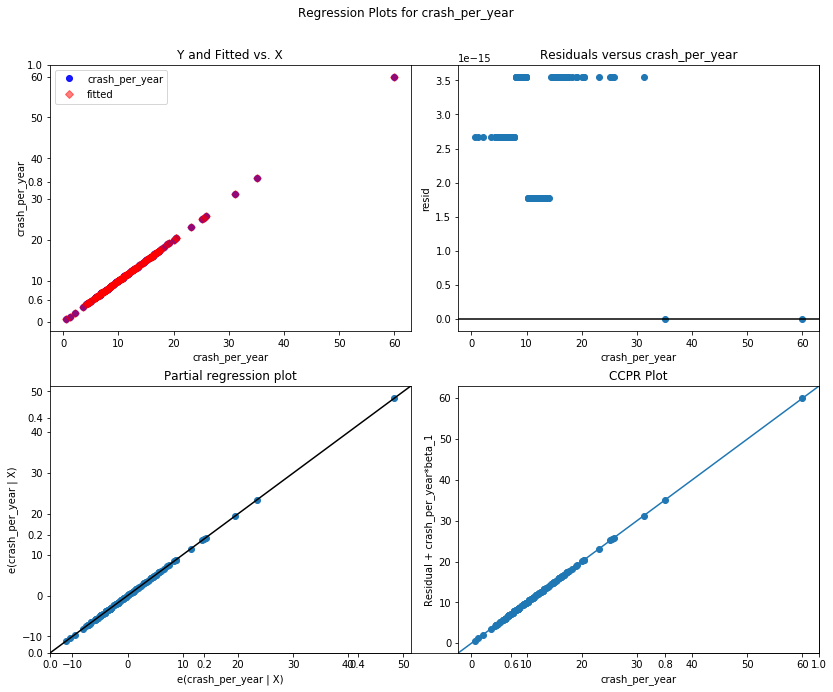

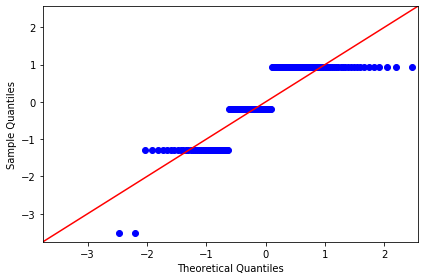


PROTECTED_TURN **** PROTECTED_TURN **** PROTECTED_TURN **** PROTECTED_TURN **** PROTECTED_TURN **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2599
Date:                Wed, 24 Feb 2021   Prob (F-statistic):              0.611
Time:                        18:50:53   Log-Likelihood:                -479.68
No. Observations:                 144   AIC:                             963.4
Df Residuals:                     142   BIC:                             969.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025    

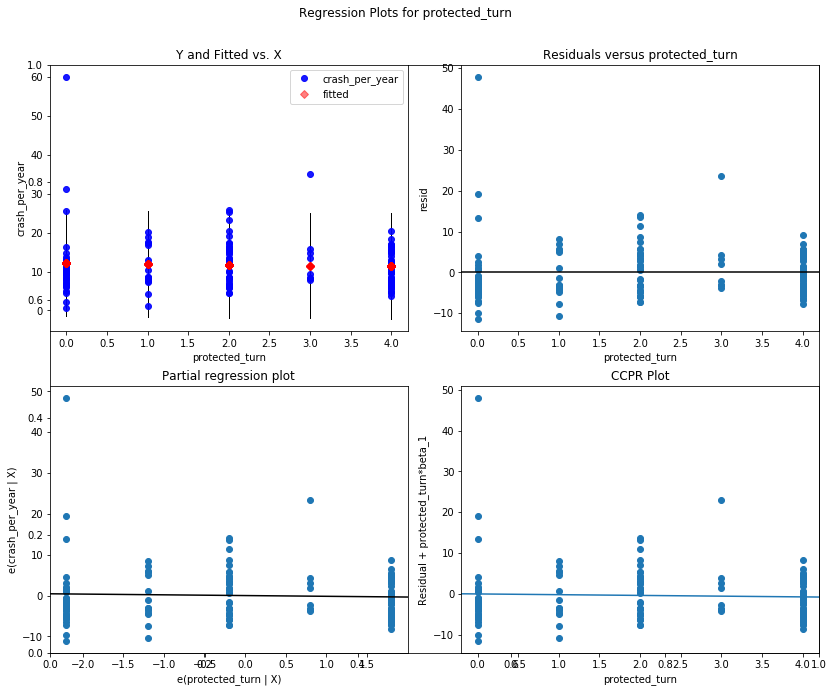

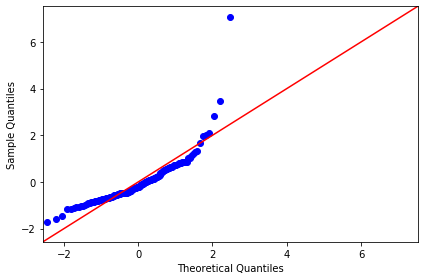


TOTAL_LANES **** TOTAL_LANES **** TOTAL_LANES **** TOTAL_LANES **** TOTAL_LANES **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     60.89
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           1.19e-12
Time:                        18:50:56   Log-Likelihood:                -454.12
No. Observations:                 144   AIC:                             912.2
Df Residuals:                     142   BIC:                             918.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------

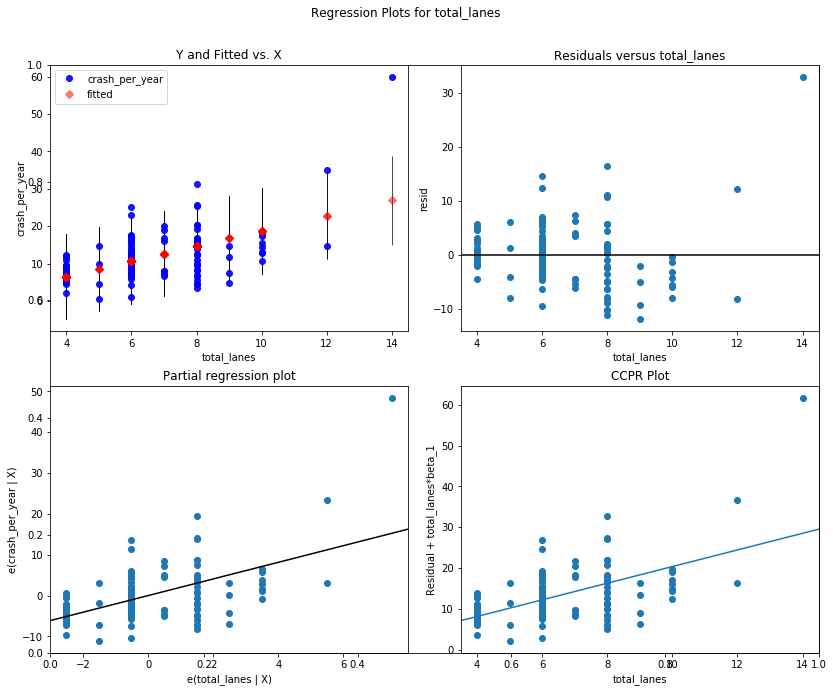

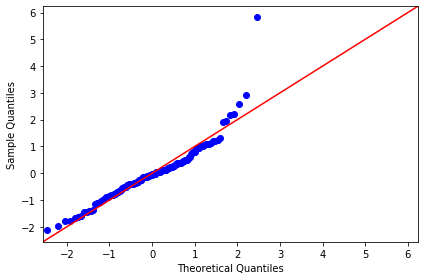


MEDIANS **** MEDIANS **** MEDIANS **** MEDIANS **** MEDIANS **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     13.11
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           0.000407
Time:                        18:50:58   Log-Likelihood:                -473.45
No. Observations:                 144   AIC:                             950.9
Df Residuals:                     142   BIC:                             956.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

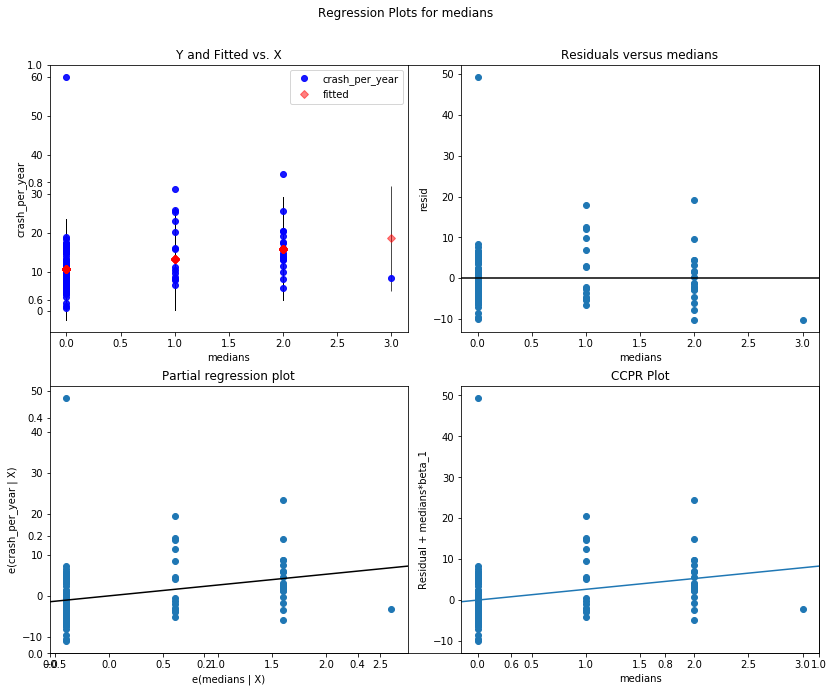

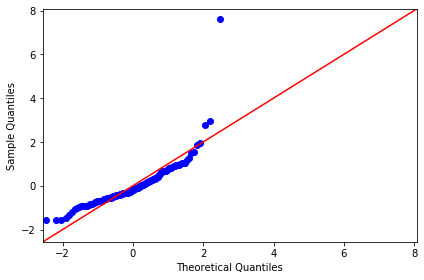


WAY **** WAY **** WAY **** WAY **** WAY **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.805
Date:                Wed, 24 Feb 2021   Prob (F-statistic):             0.0300
Time:                        18:50:59   Log-Likelihood:                -477.42
No. Observations:                 144   AIC:                             958.8
Df Residuals:                     142   BIC:                             964.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

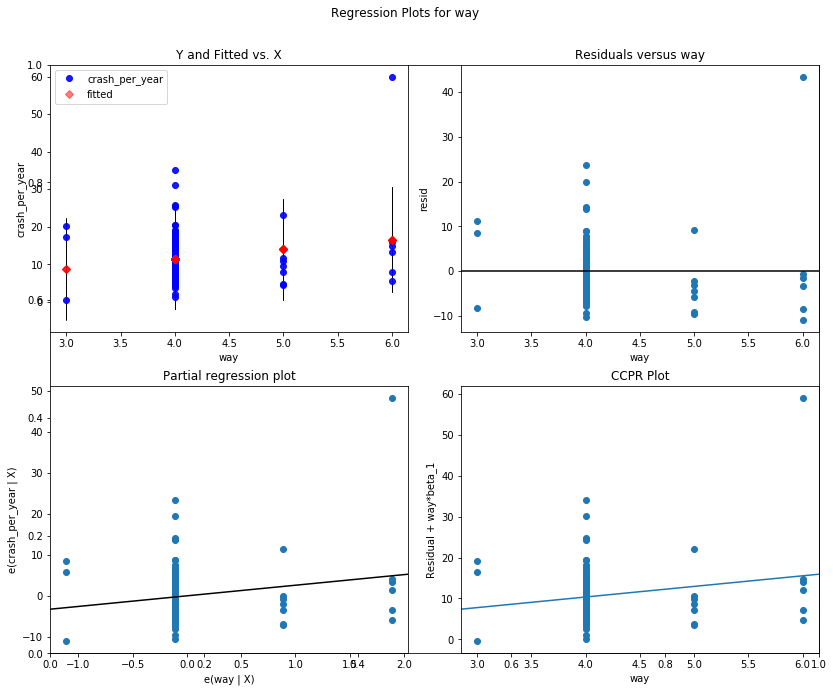

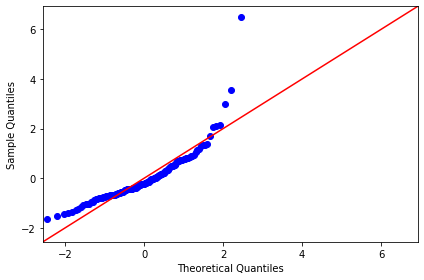


TURN_LANES **** TURN_LANES **** TURN_LANES **** TURN_LANES **** TURN_LANES **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2546
Date:                Wed, 24 Feb 2021   Prob (F-statistic):              0.615
Time:                        18:51:01   Log-Likelihood:                -479.68
No. Observations:                 144   AIC:                             963.4
Df Residuals:                     142   BIC:                             969.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

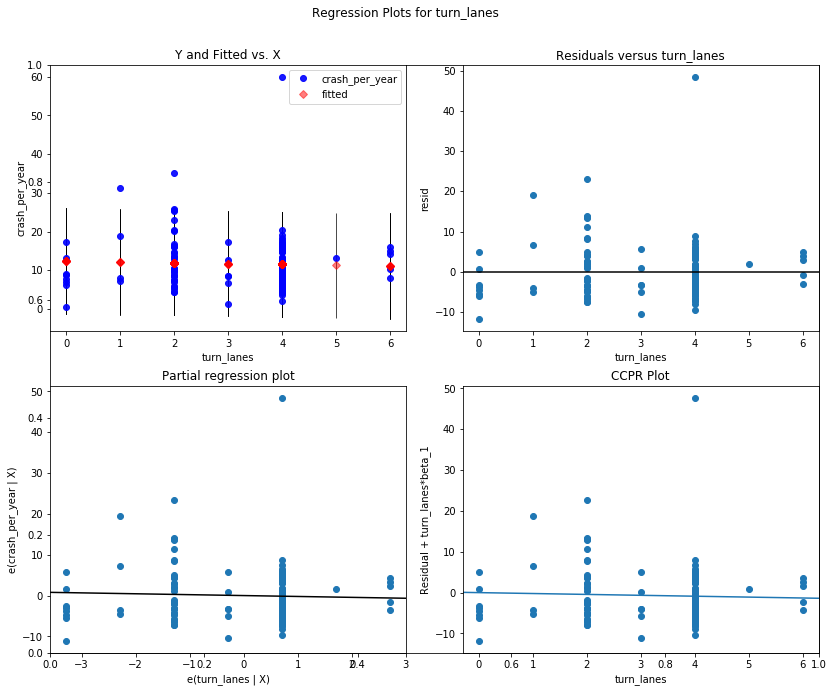

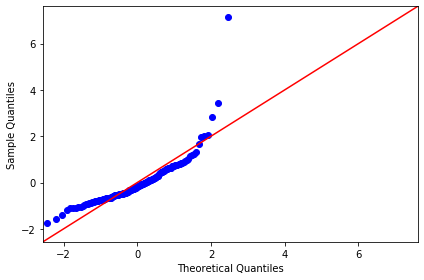


SPEED **** SPEED **** SPEED **** SPEED **** SPEED **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     18.23
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           3.55e-05
Time:                        18:51:02   Log-Likelihood:                -471.11
No. Observations:                 144   AIC:                             946.2
Df Residuals:                     142   BIC:                             952.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

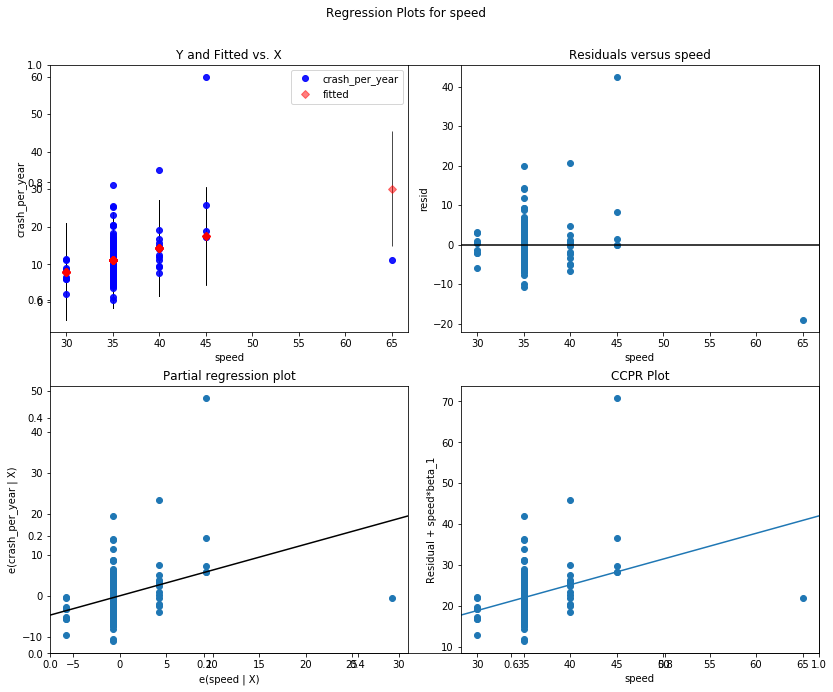

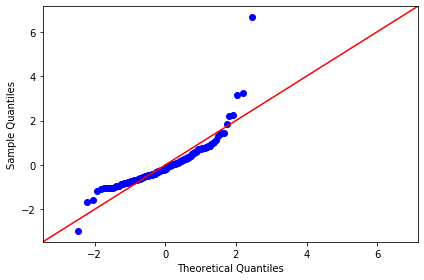


VIOLATIONS_PER_DAY **** VIOLATIONS_PER_DAY **** VIOLATIONS_PER_DAY **** VIOLATIONS_PER_DAY **** VIOLATIONS_PER_DAY **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     16.72
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           7.21e-05
Time:                        18:51:03   Log-Likelihood:                -471.80
No. Observations:                 144   AIC:                             947.6
Df Residuals:                     142   BIC:                             953.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t   

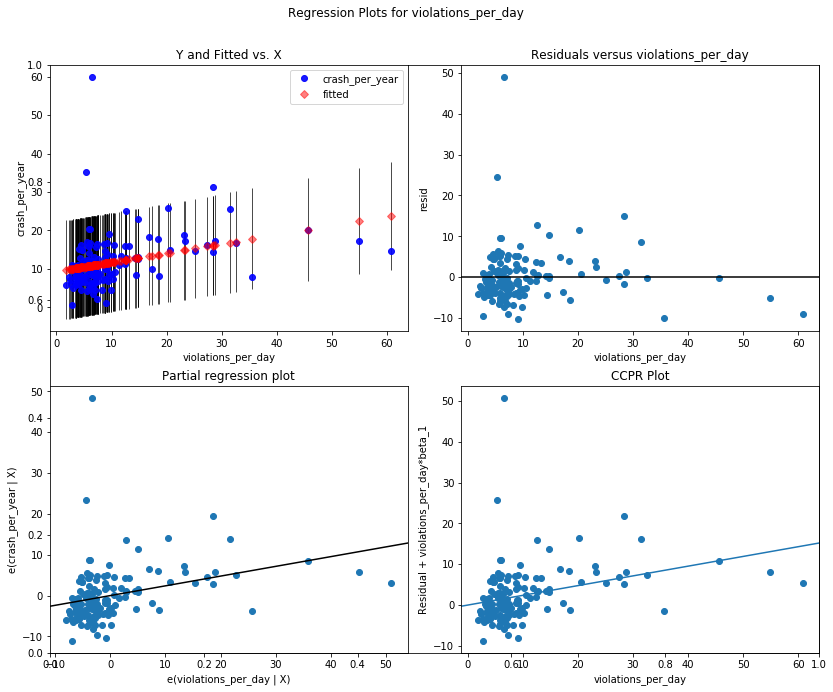

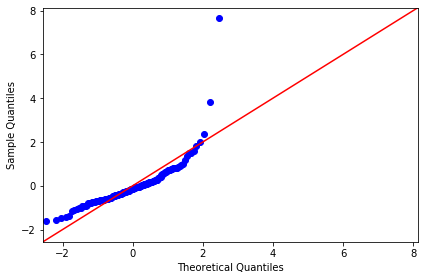


N_CAMS **** N_CAMS **** N_CAMS **** N_CAMS **** N_CAMS **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     9.714
Date:                Wed, 24 Feb 2021   Prob (F-statistic):            0.00221
Time:                        18:51:05   Log-Likelihood:                -475.05
No. Observations:                 144   AIC:                             954.1
Df Residuals:                     142   BIC:                             960.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

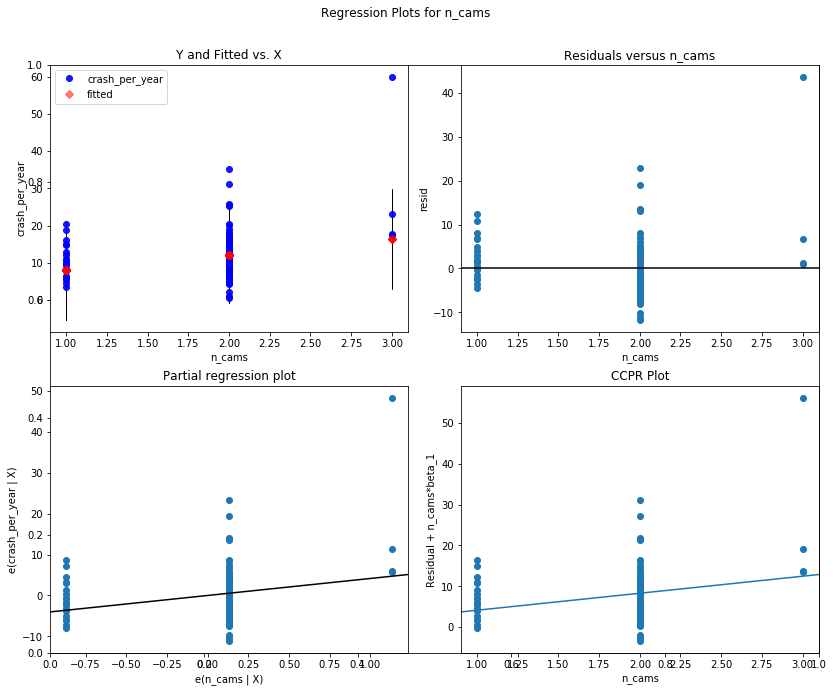

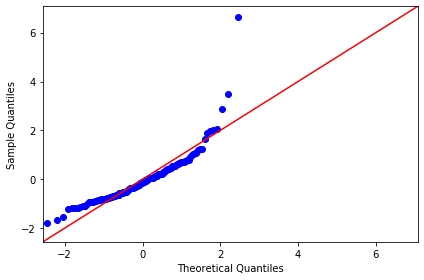


ONE_WAY **** ONE_WAY **** ONE_WAY **** ONE_WAY **** ONE_WAY **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     8.695
Date:                Wed, 24 Feb 2021   Prob (F-statistic):            0.00373
Time:                        18:51:06   Log-Likelihood:                -475.53
No. Observations:                 144   AIC:                             955.1
Df Residuals:                     142   BIC:                             961.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

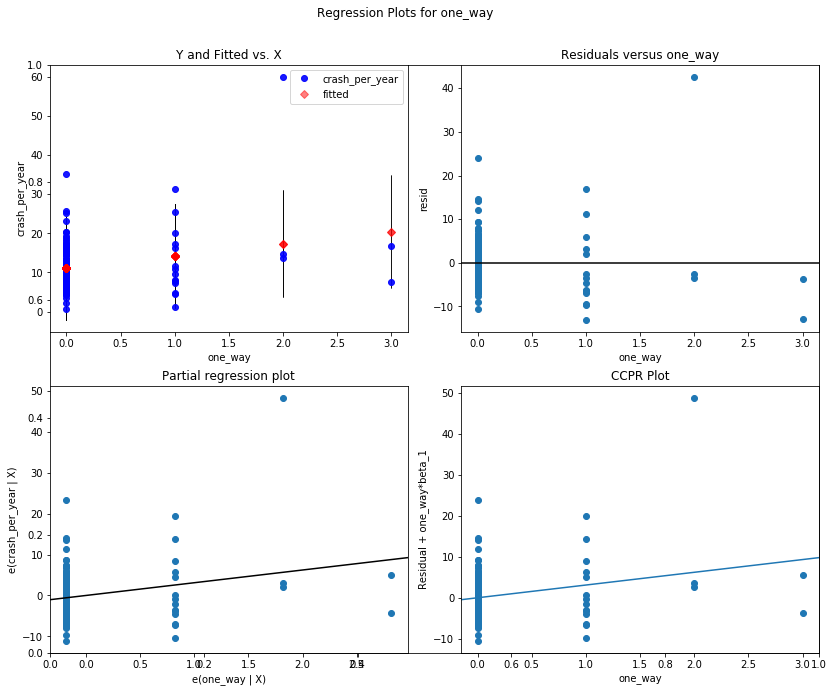

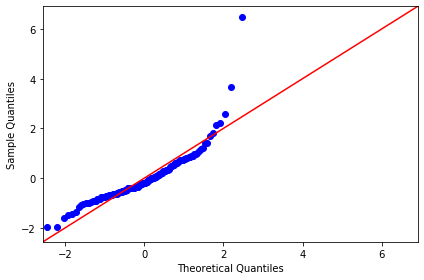


TRAFFIC_PER_LANE **** TRAFFIC_PER_LANE **** TRAFFIC_PER_LANE **** TRAFFIC_PER_LANE **** TRAFFIC_PER_LANE **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     7.141
Date:                Wed, 24 Feb 2021   Prob (F-statistic):            0.00842
Time:                        18:51:07   Log-Likelihood:                -476.28
No. Observations:                 144   AIC:                             956.6
Df Residuals:                     142   BIC:                             962.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|    

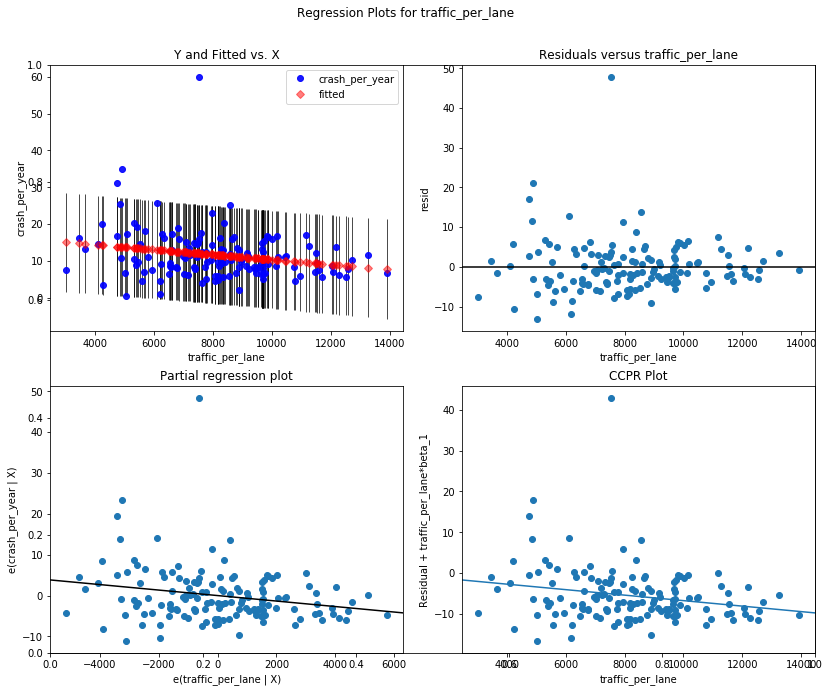

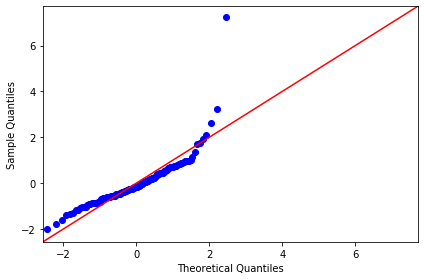


PROTECTED_RATIO **** PROTECTED_RATIO **** PROTECTED_RATIO **** PROTECTED_RATIO **** PROTECTED_RATIO **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.151
Date:                Wed, 24 Feb 2021   Prob (F-statistic):              0.285
Time:                        18:51:09   Log-Likelihood:                -479.23
No. Observations:                 144   AIC:                             962.5
Df Residuals:                     142   BIC:                             968.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.0

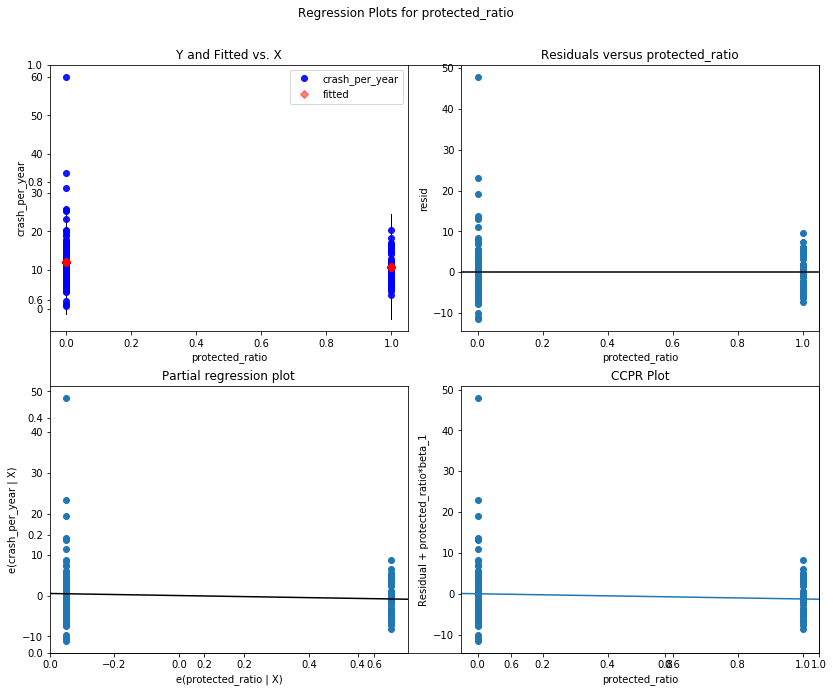

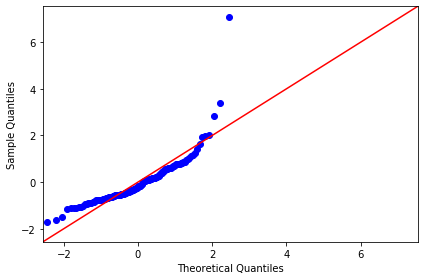


LANES_PER_DIRECTION **** LANES_PER_DIRECTION **** LANES_PER_DIRECTION **** LANES_PER_DIRECTION **** LANES_PER_DIRECTION **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     38.54
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           5.56e-09
Time:                        18:51:10   Log-Likelihood:                -462.52
No. Observations:                 144   AIC:                             929.0
Df Residuals:                     142   BIC:                             935.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err        

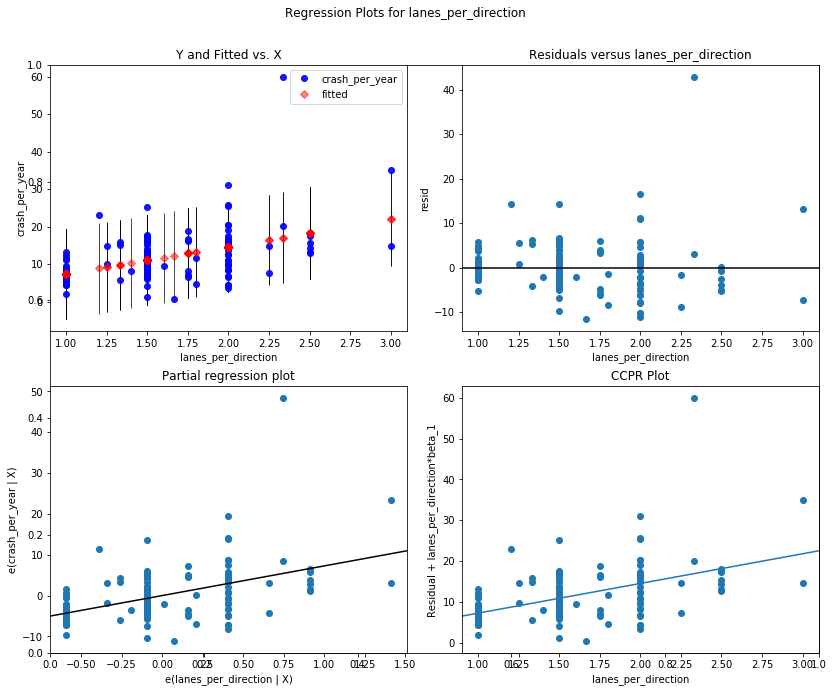

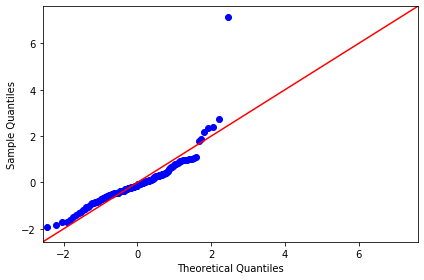


ACTIVE_CAM **** ACTIVE_CAM **** ACTIVE_CAM **** ACTIVE_CAM **** ACTIVE_CAM **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.07160
Date:                Wed, 24 Feb 2021   Prob (F-statistic):              0.789
Time:                        18:51:11   Log-Likelihood:                -479.78
No. Observations:                 144   AIC:                             963.6
Df Residuals:                     142   BIC:                             969.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

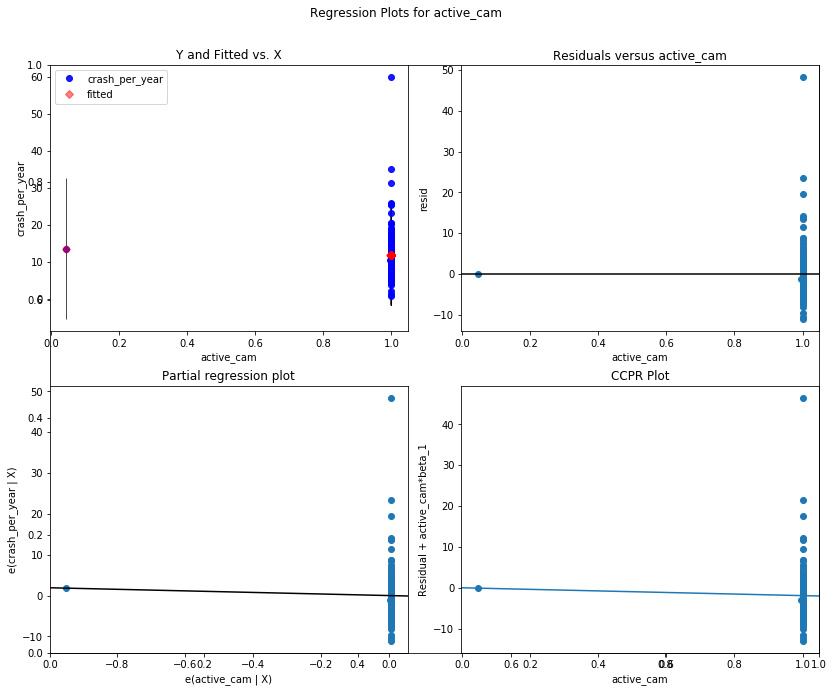

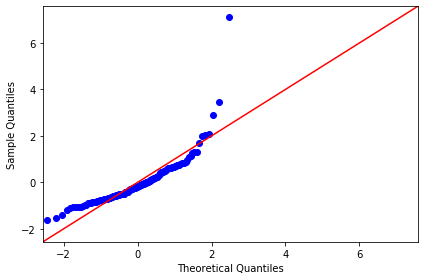


DAILY_TRAFFIC **** DAILY_TRAFFIC **** DAILY_TRAFFIC **** DAILY_TRAFFIC **** DAILY_TRAFFIC **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     15.61
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           0.000122
Time:                        18:51:13   Log-Likelihood:                -472.30
No. Observations:                 144   AIC:                             948.6
Df Residuals:                     142   BIC:                             954.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.97

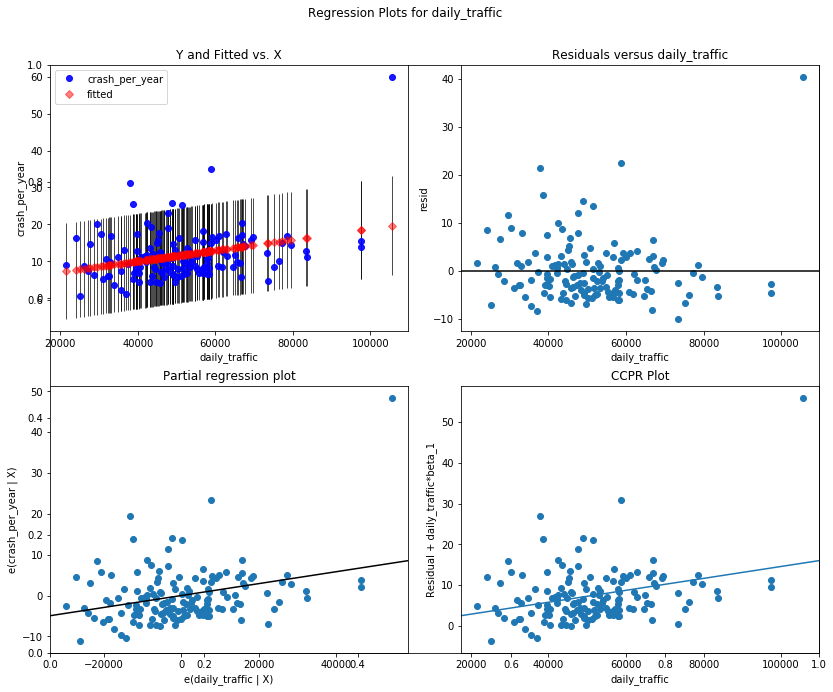

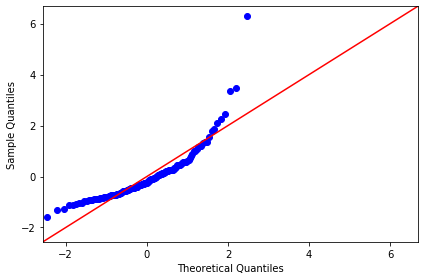


MILLION_CARS_PER_YEAR **** MILLION_CARS_PER_YEAR **** MILLION_CARS_PER_YEAR **** MILLION_CARS_PER_YEAR **** MILLION_CARS_PER_YEAR **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:         crash_per_year   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     15.61
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           0.000122
Time:                        18:51:14   Log-Likelihood:                -472.30
No. Observations:                 144   AIC:                             948.6
Df Residuals:                     142   BIC:                             954.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std

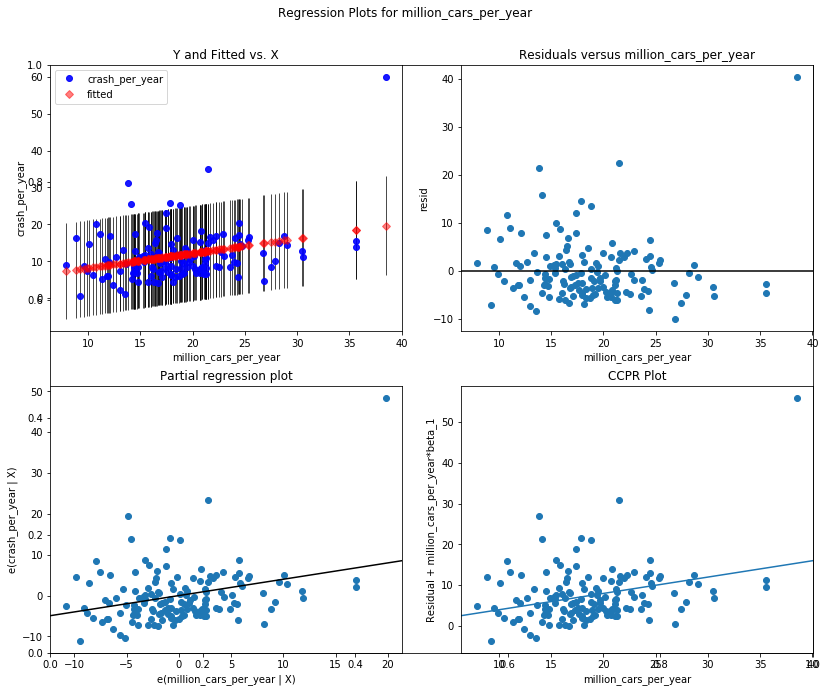

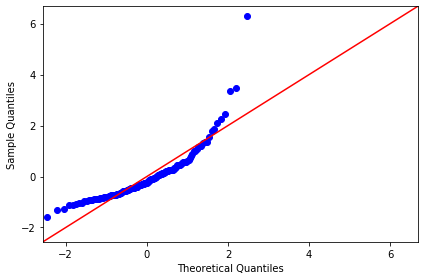

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
13,active_cam,0.000504,1.357693e+01,-1.917911,7.894128e-01,2018.477669
5,turn_lanes,0.001790,1.239295e+01,-0.219545,6.146567e-01,2046.754749
1,protected_turn,0.001827,1.206989e+01,-0.180834,6.109794e-01,1891.499856
11,protected_ratio,0.008039,1.211477e+01,-1.275736,2.852009e-01,1899.653149
4,way,0.032729,1.021272e+00,2.590670,3.001069e-02,1038.948720
10,traffic_per_lane,0.047881,1.715857e+01,-0.000673,8.415599e-03,2172.624792
9,one_way,0.057700,1.110947e+01,3.114482,3.732089e-03,985.746451
8,n_cams,0.064029,3.907860e+00,4.156162,2.213559e-03,1186.029084
3,medians,0.084533,1.062871e+01,2.635175,4.074157e-04,3168.820926
14,daily_traffic,0.099050,4.194574e+00,0.000146,1.221124e-04,852.750159


In [12]:
# Lets look at some regressions for all of my chosen columns

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# I don't need to see regression analysis for all of my variables
target = 'crash_per_year'


continuous = [target, 'protected_turn', 'total_lanes', 
              'medians', 'way','turn_lanes', 'speed',
              'violations_per_day', 'n_cams', 'one_way', 'traffic_per_lane', 'protected_ratio',
             'lanes_per_direction', 'active_cam', 'daily_traffic', 'million_cars_per_year']


categoricals = ['exit', 'split', 'underpass', 'angled', 'triangle', 'no_left', 'region_id']



df_cont = df_final[continuous]



results = []

for idx, column in enumerate(df_cont.columns):
    print()
    print((column.upper() + " **** ") * 5)
    print ("Red Light Camera Crash - Injuries")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
    fig, axes = plt.subplots(figsize=(12,10))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')

In [13]:
crash_df.columns

Index(['injuries_per_year', 'crash_per_year', 'danger_metric', 'active_cam',
       'traffic_per_lane', 'protected_ratio', 'daily_traffic',
       'million_cars_per_year', 'violations', 'complexity', 'protected_turn',
       'total_lanes', 'medians', 'exit', 'split', 'way', 'underpass',
       'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes', 'lat', 'long',
       'rlc', 'intersection', 'speed', 'n_cams', 'violations_per_day',
       'n_crash', 'injuries_total', 'injuries_fatal',
       'injuries_non_incapacitating', 'days_active', 'lanes_per_direction',
       'region_id'],
      dtype='object')

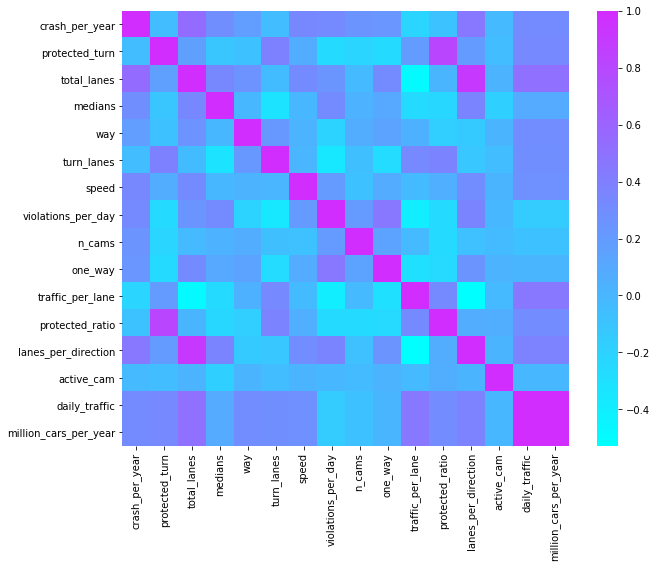

In [14]:
import seaborn as sns

# create correlation matrix
plt.figure(figsize = (10,8))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [15]:
# get rid of categories that have high correlation and others.

df_continuous = df_cont.copy()
#df_ohe = crash_df[categoricals] # defined earlier
df_ohe = df_final[categoricals] # defined earlier
df_ohe[categoricals] = df_ohe[categoricals].astype(str)

# One hot encoding   
#df_ohe = pd.get_dummies(df_ohe, columns=['way'], drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

## Feature selection

In [16]:

X_ = df_final.drop(target, axis=1)  # drop my potential targets

y = df_final[target]

In [17]:
### FEATURE SELECTION

#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge

ridge = Ridge()
selector = RFE(ridge, step=1, n_features_to_select=10)
selector = selector.fit(X_, y)
X_transformed = selector.transform(X_)

rfe_df = pd.DataFrame(list(zip(X_.columns, selector.support_, selector.ranking_, selector.estimator_.coef_)),
                  columns=['feature', 'support', 'rank', 'coef', ])

rfe_df
#rfe_df.sort_values(by=['support', 'rank'], ascending=False)

,feature,support,rank,coef
0,protected_turn,False,4,2.760470
1,total_lanes,True,1,-1.546687
2,medians,False,5,2.683829
3,way,True,1,-1.272647
4,turn_lanes,False,2,-5.109631
5,speed,False,7,-1.618286
6,violations_per_day,False,10,5.359626
7,n_cams,True,1,6.954192
8,one_way,True,1,0.697991
9,traffic_per_lane,False,11,0.870379


## Apply my feature selection to data

In [18]:
#X_ = X.iloc[:,selector.support_] 
# Chose not to keep n_cams because I consider it a mitigation put in place, not inherent to intersection
keep = ['million_cars_per_year', 'total_lanes', 'split', 'exit', 'violations_per_day', 'way', 'n_cams', 'one_way', 'turn_lanes']
X = X_[keep]

In [19]:
print(X.columns)
# this did not result in a positive r2 value.  I will manually select some of my features instead

Index(['million_cars_per_year', 'total_lanes', 'split', 'exit',
       'violations_per_day', 'way', 'n_cams', 'one_way', 'turn_lanes'],
      dtype='object')


# Linear Regression

In [20]:
# Import statsmodels.api as sm
from statsmodels.formula.api import ols

In [21]:
pred_sum = '+'.join(X.columns)
formula = target + '~' + pred_sum

In [22]:
model = ols(formula=formula, data=pd.concat([X, y], axis=1)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         crash_per_year   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     14.81
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           1.77e-16
Time:                        18:52:16   Log-Likelihood:                -430.10
No. Observations:                 144   AIC:                             880.2
Df Residuals:                     134   BIC:                             909.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -8.6000      4.429     -1.942      0.054     -17.359       0.159
split[T.1]                9.4014      2.350      4.001      0.000       4.754      14.048
exit[T.1]                 5.1494      1.765      2.918      0.004       1.659       8.640
million_cars_per_year     0.1378      0.100      1.372      0.172      -0.061       0.337
total_lanes               1.1184      0.335      3.342      0.001       0.457       1.780
violations_per_day        0.0879      0.063      1.392      0.166      -0.037       0.213
way                       0.5320      1.003      0.530      0.597      -1.452       2.516
n_cams                    2.5882      1.069      2.422      0.017       0.475       4.702
one_way                  -1.1153      1.055     -1.057      0.292      -3.202       0.971
turn_lanes                0.5069      0.379      1.338      0.183      -0.242       1.256
==============================================================================
Omnibus:                       34.075   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.813
Skew:                           0.964   Prob(JB):                     2.83e-18
Kurtosis:                       6.123   Cond. No.                         259.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The bad:
Large JB is troubling.  Errors are not normally distributed.
This is the lowest I could get the BIC and AIC.


The good
F-statistic looks okay with low pval.
Low skew value is good to see.

### Evaluate Model

In [23]:
def cross_val(model, X, y):
    # return a cross val score for my models
    pred = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    return -pred.mean()

def print_evaluate(true, predicted):  
    # print out all of my stats for the model
    mae, mse, rmse, r2 = evaluate(true, predicted)
    print('MAE: {:.2f}'.format(mae))
    print('MSE: {:.2f}'.format(mse))
    print('RMSE: {:.2f}'.format(rmse))
    print('R2 Square: {:.2f}'.format(r2))
    
def evaluate(true, predicted):
    # get multiple stats on my model predictions
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2 = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2

In [24]:
reg = LinearRegression()
reg.fit(X, y)  # my regression object

pred = reg.predict(X)

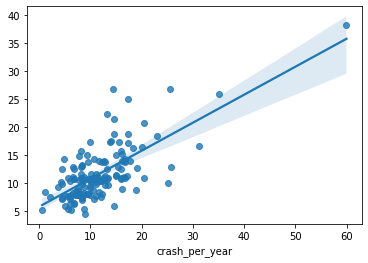

In [25]:
sns.regplot(y, pred)
# plt.xlim(0,80)
# plt.ylim(0,60)

### Plot residuals

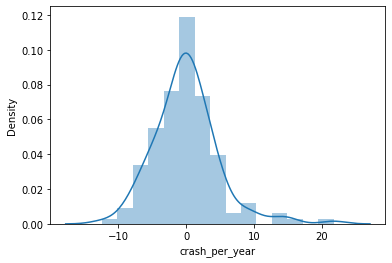

In [26]:
sns.distplot((y - pred), bins=15);

In [27]:

print("Linear Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y, pred)


Linear Regression Results:
Test set:
MAE: 3.43
MSE: 23.00
RMSE: 4.80
R2 Square: 0.50


In [28]:
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))


million_cars_per_year: 0.1378426008304534
 total_lanes: 1.1183609814509097
       split: 9.401392058997232
        exit: 5.149431659183936
violations_per_day: 0.08793069972575215
         way: 0.5319856790141824
      n_cams: 2.588166777538008
     one_way: -1.1152547575526357
  turn_lanes: 0.5068665713620613


In [29]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y, pred) , cross_val(reg, X, y)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation Score (MSE)"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation Score (MSE)
0,Linear Regression,3.425666,23.004156,4.796265,0.498675,34.44988


In [30]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

## Ridge Model

In [31]:
from sklearn.linear_model import Ridge, RidgeCV

model = Ridge()
model.fit(X, y)
pred = model.predict(X)


print("Ridge Regression Results:")
print('=========================')
print_evaluate(y, pred)


Ridge Regression Results:
MAE: 3.42
MSE: 23.11
RMSE: 4.81
R2 Square: 0.50


In [32]:
ridge = pd.DataFrame(data=[["Ridge Regression", *evaluate(y, pred) , cross_val(model, X, y)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation Score (MSE)"])
results_df.append(ridge)

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation Score (MSE)
0,Linear Regression,3.425666,23.004156,4.796265,0.498675,34.44988
0,Ridge Regression,3.420465,23.109968,4.807283,0.496369,34.78188


## Random Forest Model

In [33]:
forest_cont = ['total_lanes', 'exit', 'split', 'way',
       'angled', 'triangle', 'one_way', 'turn_lanes',
        'million_cars_per_year', 'speed', 'underpass', 'medians']

forest_cat = ['region_id']


In [34]:
df_continuous = crash_df[forest_cont]

df_ohe = crash_df[forest_cat].astype(str)
df_ohe = pd.get_dummies(df_ohe, columns=forest_cat, drop_first=True)

df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [35]:
from sklearn.model_selection import train_test_split

X = df_final
y = crash_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

In [36]:
from sklearn.ensemble import RandomForestRegressor
base = RandomForestRegressor(random_state = 42)
base.fit(X_train, y_train)

base.score(X_test, y_test)

0.3212901519808381

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40],
    'max_features': [5, 10, 15, 20],
    'min_samples_leaf': [5],
    'min_samples_split': [2],
    'n_estimators': [200, 300, 1000]
}

# Create a based model
forest = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

#grid_search.fit(X_train, y_train)


In [37]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 500, 
                               random_state = 42, 
                               max_features=17, 
                               max_depth=12,
                              )
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features=17, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [38]:
#y_pred = forest.predict(X_test)
y_pred = forest.predict(X)

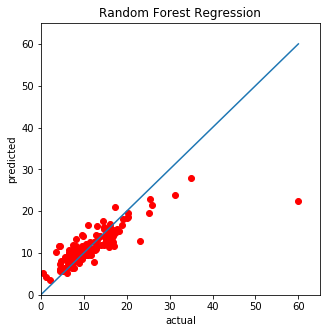

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# # Visualising the Random Forest Regression Results  
plt.figure(figsize=[5,5])
plt.scatter(y, y_pred, color='red')
plt.plot([0,60], [0, 60])
plt.title('Random Forest Regression')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.xlim(0,65)
plt.ylim(0,65)
plt.show()

In [41]:
print(forest.score(X_test, y_test)) # r2
df = pd.DataFrame(list(zip(X_test.columns, forest.feature_importances_)), columns=['feature', 'importance'])
df.sort_values(by='importance', ascending=False)[:10]


0.32465904852750116


,feature,importance
0,total_lanes,0.221930
8,million_cars_per_year,0.156709
11,medians,0.123550
2,split,0.068969
9,speed,0.068444
7,turn_lanes,0.055505
28,region_id_26,0.031693
5,triangle,0.025824
1,exit,0.025063
3,way,0.024143


In [42]:
# this intersection throws almost needs it's own category.  It's insane
crash_df[crash_df.n_crash==200]['intersection']

139    STONEY ISLAND AND 79TH
Name: intersection, dtype: object

In [43]:
# Get mae to compare it
print('Average crashes per year (per intersection): {:.1f}'.format(y.mean()))
print('Max crashes per year: {:.1f}'.format(y.max()))
print('Min crashes per year: {:.1f}'.format(y.min()))
print('Std dev crashes per year: {:.1f}'.format(y.std()))


print()

print("Model on X_test set:")
pred = forest.predict(X_test)
print_evaluate(y_test, pred)

print()
pred= forest.predict(X)
print('Model on X set:')
print_evaluate(y, pred)



Average crashes per year (per intersection): 11.7
Max crashes per year: 60.0
Min crashes per year: 0.6
Std dev crashes per year: 6.8

Model on X_test set:
MAE: 5.07
MSE: 68.15
RMSE: 8.26
R2 Square: 0.32

Model on X set:
MAE: 2.22
MSE: 16.97
RMSE: 4.12
R2 Square: 0.63


This is not a great result for the random forest.  It did not fare much better than the regressions.  I cold tune the hyperparameters, but will stick with Ridge regression for now.

## Results of intersection characteristic analysis
Linear Regression gave the better results.  I kept it because of the better cross validation and the ability to interpret the results.  The r2 value is not as meaningful since we trained and scored on the same set. 

Characteristics used : 'traffic', 'total_lanes', 'medians', 'speed', 'violations_per_year', 'n_cams'
Most important characteristics (by rank): 'total_lanes', 'cams'

These characteristics accounted for about half of the crashes by r-square value.  Adding in more characteristics improves performance, but the individual p_vals do not support their inclusion, and would risk overfitting on a small dataset.

From our linear regression coefficients:
Every 50 violations is one more accident per year. (this is the best predictor we have)
A 6 way intersection will have about 5 more accidents per year. (2.5 per way)
Each additional lane adds about one accident per year.
An intersection with 10mph higher speed limit has one more accident per year.


Only a handful of the gathered characteristics meaningfully informed the model.
One possible hypothesis: dangerous intersections have had characteristics changed to mitigate the accidents.  Medians, no turns, protected turns, no left, cameras etc. were installed to make the intersection safer.  Perhaps they only occur at the more dangerous intersections, and their presence is the result rather than the cause of the accidents and should not be considered.  For this reason, I chose to only keep variables that were inherent to the intersection, and could not be mitigated (lanes, ways, traffic, violations, split, triangles, overpasses, exits).


The random forest model produced a higher score (MSE) than the linear model.  It used similar features (violations, lanes, and traffic added the most predictive value to the model)